# Notebook 2: Gradient Descent

Group nickname: MuonGang
    
Participants: 
 - Alessandro Valente 1234429 
 -             Ardino Rocco 1231629 
 -           Andrea Paccagnella 

## Learning Goal

The goal of this notebook is to gain intuition for various gradient descent methods by visualizing and applying these methods to some simple two-dimensional surfaces. Methods studied include ordinary gradient descent, gradient descent with momentum, NAG, ADAM, and RMSProp.


## Overview

In this notebook, we will visualize what different gradient descent methods are doing using some simple surfaces. From the onset, we emphasize that doing gradient descent on the surfaces is different from performing gradient descent on a loss function in Machine Learning (ML). The reason is that in ML not only do we want to find good minima, we want to find good minima that generalize well to new data. Despite this crucial difference, we can still build intuition about gradient descent methods by applying them to simple surfaces (see related blog posts [here](http://ruder.io/optimizing-gradient-descent/) and [here](http://tiao.io/notes/visualizing-and-animating-optimization-algorithms-with-matplotlib/)).

## Surfaces

We will consider three simple surfaces: a quadratic minimum of the form $$z=ax^2+by^2,$$ a saddle-point of the form $$z=ax^2-by^2,$$ and [Beale's Function](https://en.wikipedia.org/wiki/Test_functions_for_optimization), a convex function often used to test optimization problems of the form:
$$z(x,y) = (1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2$$

These surfaces can be plotted using the cells below. 


In [1]:
#This cell sets up basic plotting functions awe
#we will use to visualize the gradient descent routines.

#Make plots interactive
#%matplotlib notebook

#Make plots static
%matplotlib inline

#Make 3D plots
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
#from matplotlib import animation
from IPython.display import HTML
from matplotlib.colors import LogNorm
#from itertools import zip_longest

#Import Numpy
import numpy as np
import time

#Define function for plotting 

def plot_surface(x, y, z, azim=-60, elev=40, dist=10, cmap="RdYlBu_r", fig=plt.figure(), subplot_id=111, title='plot'):

    # fig = plt.figure()
    ax = fig.add_subplot(subplot_id, projection='3d')
    plot_args = {'rstride': 1, 'cstride': 1, 'cmap':cmap,
             'linewidth': 20, 'antialiased': True,
             'vmin': -2, 'vmax': 2}
    ax.plot_surface(x, y, z, **plot_args)
    ax.view_init(azim=azim, elev=elev)
    ax.dist=dist
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-2, 2)
    
    plt.xticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    plt.yticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    ax.set_zticks([-2, -1, 0, 1, 2])
    ax.set_zticklabels(["-2", "-1", "0", "1", "2"])
    
    ax.set_xlabel("x", fontsize=18)
    ax.set_ylabel("y", fontsize=18)
    ax.set_zlabel("z", fontsize=18)
    
    ax.set_title(title, fontsize=18)
    return ax;

def overlay_trajectory_quiver(ax,obj_func,trajectory, color='k'):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    zs=obj_func(xs,ys)
    ax.quiver(xs[:-1], ys[:-1], zs[:-1], xs[1:]-xs[:-1], ys[1:]-ys[:-1],zs[1:]-zs[:-1],color=color,arrow_length_ratio=0.3)
    
    return ax;

def overlay_trajectory(ax,obj_func,trajectory,label,color='k'):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    zs=obj_func(xs,ys)
    ax.plot(xs,ys,zs, color, label=label)
    
    return ax;

    
def overlay_trajectory_contour_M(ax,trajectory, label,color='k', lw=2, ms=14):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    ax.plot(xs[-1],ys[-1],color+'>', markersize=ms)
    return ax;

def overlay_trajectory_contour(ax,trajectory, label,color='k', lw=2, ms=5):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw, markersize=ms)
    return ax;

<Figure size 432x288 with 0 Axes>

In [2]:
#DEFINE SURFACES WE WILL WORK WITH

#Define monkey saddle and gradient
def monkey_saddle(x,y):
    return x**3 - 3*x*y**2

def grad_monkey_saddle(params):
    x=params[0]
    y=params[1]
    grad_x= 3*x**2-3*y**2
    grad_y= -6*x*y
    return [grad_x,grad_y]

#Define saddle surface

def saddle_surface(x,y,a=1,b=1):
    return a*x**2-b*y**2

def grad_saddle_surface(params,a=1,b=1):
    x=params[0]
    y=params[1]
    grad_x= a*x
    grad_y= -1*b*y
    return [grad_x,grad_y]


# Define minima_surface

def minima_surface(x,y,a=1,b=1):
    return a*x**2+b*y**2-1

def grad_minima_surface(params,a=1,b=1):
    x=params[0]
    y=params[1]
    grad_x= 2*a*x
    grad_y= 2*b*y
    return [grad_x,grad_y]


def beales_function(x,y):
    return np.square(1.5-x+x*y)+np.square(2.25-x+x*y*y)+np.square(2.625-x+x*y**3)
    return f

def grad_beales_function(params):
    x=params[0]
    y=params[1]
    grad_x=2*(1.5-x+x*y)*(-1+y)+2*(2.25-x+x*y**2)*(-1+y**2)+2*(2.625-x+x*y**3)*(-1+y**3)
    grad_y=2*(1.5-x+x*y)*x+4*(2.25-x+x*y**2)*x*y+6*(2.625-x+x*y**3)*x*y**2
    return [grad_x,grad_y]

def contour_beales_function():
    #plot beales function
    x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
    fig, ax = plt.subplots(figsize=(10, 10))
    z=beales_function(x,y)
    cax = ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
    ax.plot(3,0.5, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((-4.5, 4.5))
    ax.set_ylim((-4.5, 4.5))
    
    return fig,ax

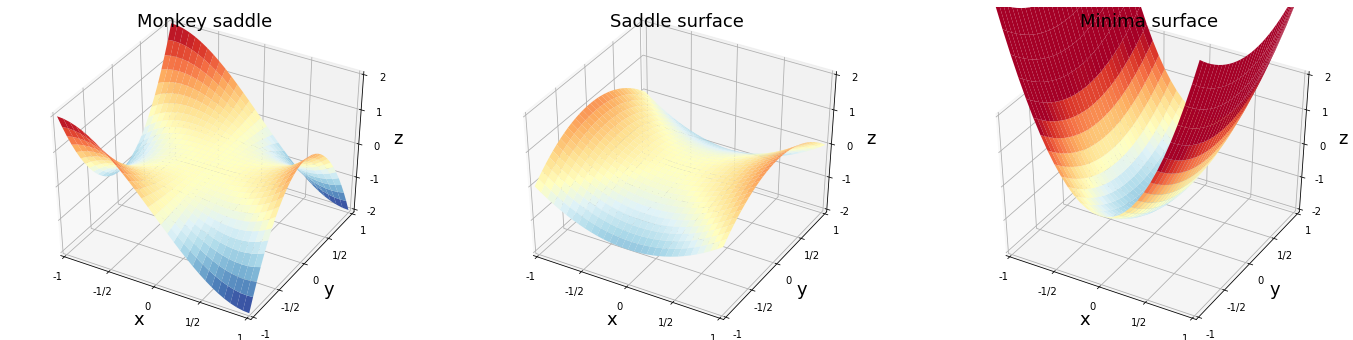

In [3]:
#Make plots of surfaces
plt.close() # closes previous plots
fig = plt.figure(figsize=(24,6))
x, y = np.mgrid[-1:1:31j, -1:1:31j]
ax1=plot_surface(x,y,monkey_saddle(x,y),fig=fig, subplot_id=131, title='Monkey saddle')
ax2=plot_surface(x,y,saddle_surface(x,y),fig=fig, subplot_id=132, title='Saddle surface')
ax3=plot_surface(x,y,minima_surface(x,y,5),fig=fig, subplot_id=133, title='Minima surface')

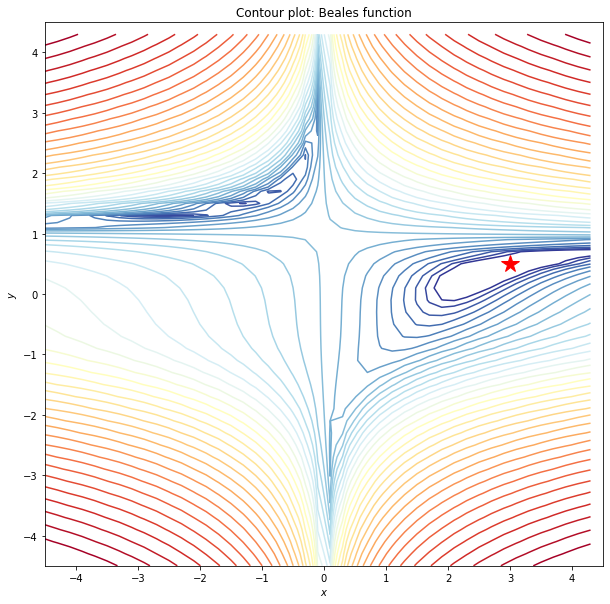

In [4]:
#Contour plot of Beale's Function
fig4,ax4 =contour_beales_function()
ax4.set_title('Contour plot: Beales function')
plt.show()

## Gradient descent with and without momentum

In this notebook, we will visualize various gradient descent algorithms used in machine learning. We will be especially interested in trying to understand how various hyperparameters -- especially the learning rate -- affect our performance. Here, we confine ourselves primarily to looking at the performance in the absence of noise. However, we encourage the reader to experiment with playing with the noise strength below and seeing what differences introducing stochasticity makes. 

Throughout, we denote the parameters by $\theta$ and the energy function we are trying to minimize by $E(\theta)$.

<b>Gradient Descent</b>

We start by considering a simple gradient descent method. In this method,
we will take steps in the direction of the local gradient. Given some parameters $\theta$, we adjust the parameters at each iteration so that

$$\theta_{t+1}= \theta_t - \eta_t \nabla_\theta E(\theta),$$

where we have introduced the learning rate $\eta_t$ that controls how large a step we take. In general, the algorithm is extremely sensitive to the choice of $\eta_t$. If $\eta_t$ is too large, then one can wildly oscillate around minima and miss important structure at small scales. This problem is amplified if our gradient computations are noisy and inexact (as is often the case in machine learning applications). If $\eta_t$ is too small, then the learning/minimization procedure becomes extremely slow. This raises the natural question: <i> What sets the natural scale for the learning rate and how can we adaptively choose it?</i> We discuss this extensively in Section IV of the review.

<b>Gradient Descent with Momentum</b>

One problem with gradient descent is that it has no memory of where the "ball rolling down the hill" comes from. This can be an issue when there are many shallow minima in our landscape. If we make an analogy with a ball rolling down a hill, the lack of memory is equivalent to having no inertia or momentum (i.e. completely overdamped dynamics). Without momentum, the ball has no kinetic energy and cannot climb out of shallow minima. 

Momentum becomes especially important when we start thinking about stochastic gradient descent with noisy, stochastic estimates of the gradient. In this case, we should remember where we were coming from and not react drastically to each new update.



Inspired by this, we can add a memory or momentum term to the stochastic gradient descent term above:

$$
v_{t}=\gamma v_{t-1}+\eta_{t}\nabla_\theta E(\theta_t),\\
\theta_{t+1}= \theta_t -v_{t},
$$

with $0\le \gamma < 1$ called the momentum parameter. When $\gamma=0$, this reduces to ordinary gradient descent, and increasing $\gamma$ increases the inertial contribution to the gradient. From the equations above, we can see that typical memory lifetimes of the gradient is given by $(1-\gamma)^{-1}$. For $\gamma=0$ as in gradient descent, the lifetime is just one step. For $\gamma=0.9$, we typically remember a gradient for ten steps. We will call this gradient descent with classical momentum or CM for short.

A final widely used variant of gradient descent with momentum is called the Nesterov accelerated gradient (NAG). In NAG, rather than calculating the gradient at the current position, one calculates the gradient at the position momentum will carry us to at time $t+1$, namely, $\theta_t -\gamma v_{t-1}$. Thus, the update becomes
$$
v_{t}=\gamma v_{t-1}+\eta_{t}\nabla_\theta E(\theta_t-\gamma v_{t-1})\\
\theta_{t+1}= \theta_t -v_{t}
$$

In [5]:
#This writes a simple gradient descent, gradient descent+ momentum,
#nesterov. 

#Mean-gradient based methods
def gd(grad, init, n_epochs=1000, eta=10**-4, noise_strength=0, TIME_FLAG=False):
    #This is a simple optimizer
    if TIME_FLAG: 
        start=time.process_time()
        times=[0]
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
        if TIME_FLAG: times.append(time.process_time()-start)
    if TIME_FLAG: return param_traj, np.array(times)
    else: return param_traj


def gd_with_mom(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0, TIME_FLAG=False):
    if TIME_FLAG: 
        start=time.process_time()
        times=[0]
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=gamma*v+eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
        if TIME_FLAG: times.append(time.process_time()-start)
    if TIME_FLAG: return param_traj, np.array(times)
    else: return param_traj

def NAG(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0, TIME_FLAG=False):
    if TIME_FLAG: 
        start=time.process_time()
        times=[0]
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        params_nesterov=params-gamma*v
        v=gamma*v+eta*(np.array(grad(params_nesterov))+noise)
        params=params-v
        param_traj[j+1,]=params
        if TIME_FLAG: times.append(time.process_time()-start)
    if TIME_FLAG: return param_traj, np.array(times)
    else: return param_traj

## Experiments with GD, CM, and NAG

Before introducing more complicated situations, let us experiment with these methods to gain some intuition.

Let us look at the dependence of GD on learning rate in a simple quadratic minima of the form $z=ax^2+by^2-1$. Make  plots below for $\eta=0.1,0.5,1,1.01$ and $a=1$ and $b=1$. (to do this, you would have to add additional arguments to the function `gd` above in order to pass the new values of `a` and `b`; otherwise the default values `a=1` and `b=1` will be used by the gradient)
<ul>
<li>
What are the qualitatively different behaviors that arise as $\eta$ is increased?
<li> What does this tell us about the importance of choosing learning parameters? How do these change if we change $a$ and $b$ above? In particular how does anisotropy change the learning behavior?
<li> Make similar plots for CM and NAG? How do the learning rates for these procedures compare with those for GD?
</ul>


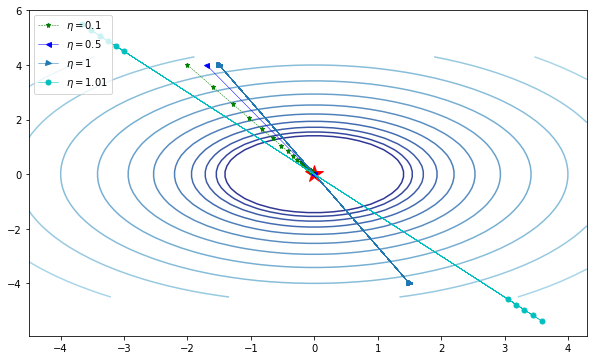

In [6]:
# Investigate effect of learning rate in GD
plt.close()
a,b = 1.0,1.0
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=np.abs(minima_surface(x,y,a,b))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

#initial point
init1=[-2,4]
init2=[-1.7,4]
init3=[-1.5,4]
init4=[-3,4.5]
eta1=0.1
eta2=0.5
eta3=1
eta4=1.01
gd_1=gd(grad_minima_surface,init1, n_epochs=100, eta=eta1)
gd_2=gd(grad_minima_surface,init2, n_epochs=100, eta=eta2)
gd_3=gd(grad_minima_surface,init3, n_epochs=100, eta=eta3)
gd_4=gd(grad_minima_surface,init4, n_epochs=10,  eta=eta4)
#print(gd_1)
overlay_trajectory_contour(ax,gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5, ms=5)
overlay_trajectory_contour(ax,gd_2,'$\eta=$%s'% eta2,'b-<',  lw=0.5, ms=5)
overlay_trajectory_contour(ax,gd_3,'$\eta=$%s'% eta3,'->',   lw=0.5, ms=5)
overlay_trajectory_contour(ax,gd_4,'$\eta=$%s'% eta4,'c-o',  lw=0.5, ms=5)
plt.legend(loc=2)
plt.show()
fig.savefig("GD3regimes.pdf", bbox_inches='tight')


## Gradient Descents that utilize the second moment

In stochastic gradient descent, with and without momentum, we still have to specify a  schedule for tuning the learning rates $\eta_t$ as a function of time. As discussed in Sec. IV in the context of Newton's method, this presents a number of dilemmas. The learning rate is limited by the steepest direction which can change depending on where in the landscape we are. To circumvent this problem, ideally our algorithm would take large steps in shallow, flat directions and small steps in steep, narrow directions. Second-order methods accomplish this by calculating or approximating the Hessian and normalizing the learning rate by the curvature. However, this is very computationally expensive for extremely large models.  Ideally, we would like to be able to adaptively change our step size to match the landscape without paying the steep computational price of calculating or approximating Hessians.

Recently, a number of methods have been introduced that accomplish this by tracking not only the gradient but also the second moment of the gradient. These methods include AdaGrad, AdaDelta, RMS-Prop, and ADAM. Here, we discuss the latter of these two as representatives of this class of algorithms.

<b>RMS-Prop</b>

In RMS prop (Root-Mean-Square propagation), in addition to keeping a running average of the first moment of the gradient, we also keep track of the second moment through a moving average. The update rule for RMS prop is given by
$$
\mathbf{g}_t = \nabla_\theta E(\boldsymbol{\theta}) \\
\mathbf{s}_t =\beta \mathbf{s}_{t-1} +(1-\beta)\mathbf{g}_t^2 \nonumber \\
\boldsymbol{\theta}_{t+1}=\boldsymbol{\theta}_t + \eta_t { \mathbf{g}_t \over \sqrt{\mathbf{s}_t +\epsilon}}, \nonumber \\
$$
where $\beta$ controls the averaging time of the second moment and is typically taken to be about $\beta=0.9$, $\eta_t$ is a learning rate typically chosen to be $10^{-3}$, and $\epsilon\sim 10^{-8}$ is a small regularization constant to prevent divergences. It is clear from this formula that the learning rate is reduced in directions where the norm of the gradient is consistently large. This greatly speeds up the convergence by allowing us to use a larger learning rate for flat directions.

<b>ADAM</b>

A related algorithm is the ADAM optimizer. In ADAM, we keep a running average of both the first and second moment of the gradient and use this information to adaptively change the learning rate for different parameters. In addition to keeping a running average of the first and second moments of the gradient, ADAM performs an additional bias correction to account for the fact that we are estimating the first two moments of the gradient using a running average (denoted by the hats in the update rule below). The update rule for ADAM is given by (where multiplication and division are understood to be element wise operations)
$$
\mathbf{g}_t = \nabla_\theta E(\boldsymbol{\theta}) \\
\mathbf{m}_t = \beta_1 \mathbf{m}_{t-1} + (1-\beta_1) \mathbf{g}_t \nonumber \\
\mathbf{s}_t =\beta_2 \mathbf{s}_{t-1} +(1-\beta_2)\mathbf{g}_t^2 \nonumber \\
\hat{\mathbf{m}}_t={\mathbf{m}_t \over 1-\beta_1} \nonumber \\
\hat{\mathbf{s}}_t ={\mathbf{s}_t \over1-\beta_2} \nonumber \\
\boldsymbol{\theta}_{t+1}=\boldsymbol{\theta}_t + \eta_t { \hat{\mathbf{m}}_t \over \sqrt{\hat{\mathbf{s}}_t +\epsilon}}, \nonumber 
$$
where $\beta_1$ and $\beta_2$ set the memory lifetime of the first and second moment and are typically take to be $0.9$ and $0.99$ respectively, and $\eta$ and $\epsilon$ are identical
to RMSprop.




In [7]:
################################################################################
# Methods that exploit first and second moments of gradient: RMS-PROP and ADAMS
################################################################################

def rms_prop(grad, init, n_epochs=5000, eta=10**-3, beta=0.9,epsilon=10**-8,noise_strength=0, TIME_FLAG=False):
    if TIME_FLAG: 
        start=time.process_time()
        times=[0]
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init#Import relevant packages
    grad_sq=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v=eta*np.divide(g,np.sqrt(grad_sq+epsilon))
        params= params-v
        param_traj[j+1,]=params
        if TIME_FLAG: times.append(time.process_time()-start)
    if TIME_FLAG: return param_traj, np.array(times)
    else: return param_traj
                        
                        
def adams(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0, TIME_FLAG=False):
    if TIME_FLAG: 
        start=time.process_time()
        times=[0]
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0;
    grad_sq=0;
    for j in range(1,n_epochs+1):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        v=gamma*v+(1-gamma)*g
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v_hat=v/(1-gamma**j)
        grad_sq_hat=grad_sq/(1-beta**j)
        params=params-eta*np.divide(v_hat,np.sqrt(grad_sq_hat)+epsilon)
        param_traj[j,]=params
        if TIME_FLAG: times.append(time.process_time()-start)
    if TIME_FLAG: return param_traj, np.array(times)
    else: return param_traj

## Experiments with ADAM and RMSprop

In this section, we will experiment with ADAM and RMSprop. To do so, we will use a function commonly used in optimization protocols:

$$
f(x,y)=(1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2.
$$

This function has a global minimum at $(x,y)=(3,0.5)$. We will use GD, GD with classical momentum, NAG, RMSprop, and ADAM to find minima starting at different initial conditions.

One of the things you should experiment with is the learning rate and the number of steps, $N_{\mathrm{steps}}$ we take. Initially, we have set $N_{\mathrm{steps}}=10^4$ and the learning rate for ADAM/RMSprop to $\eta=10^{-3}$ and the learning rate for the remaining methods to $10^{-6}$.
<ul>
<li> Examine the plot for these default values. What do you see?
<li> Make a plot when the learning rate of all methods is $\eta=10^{-6}$? How does your plot change?
<li> Now set the learning rate for all algorithms to $\eta=10^{-3}$? What goes wrong? Why?
</ul>

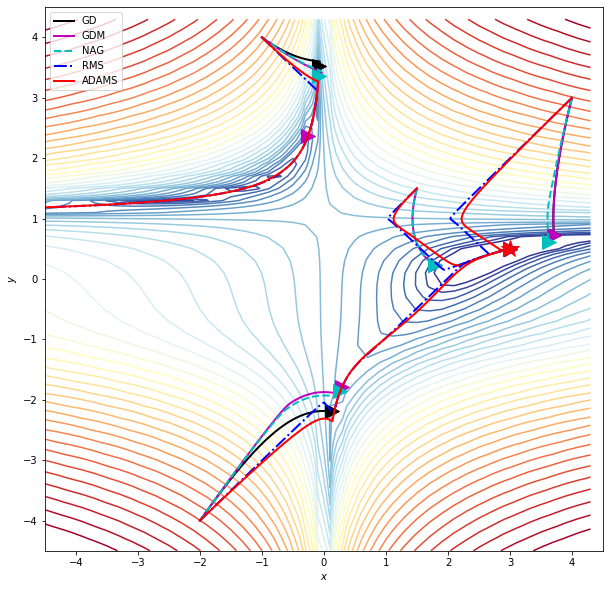

In [8]:
plt.close()
#Make static plot of the results
Nsteps=10**4
lr_l=10**-3
lr_s=10**-6

init1=np.array([4,3])
fig1, ax1=contour_beales_function()

gd_trajectory1=gd(grad_beales_function,init1,Nsteps, eta=lr_s, noise_strength=0)
gdm_trajectory1=gd_with_mom(grad_beales_function,init1,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
NAG_trajectory1=NAG(grad_beales_function,init1,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
rms_prop_trajectory1=rms_prop(grad_beales_function,init1,Nsteps,eta=lr_l, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory1=adams(grad_beales_function,init1,Nsteps,eta=lr_l, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

overlay_trajectory_contour_M(ax1,gd_trajectory1, 'GD','k')
overlay_trajectory_contour_M(ax1,gd_trajectory1, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory1, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory1,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory1,'ADAMS', 'r')

plt.legend(loc=2)

init2=np.array([1.5,1.5])
gd_trajectory2=gd(grad_beales_function,init2,Nsteps, eta=10**-6, noise_strength=0)
gdm_trajectory2=gd_with_mom(grad_beales_function,init2,Nsteps,eta=10**-6, gamma=0.9,noise_strength=0)
NAG_trajectory2=NAG(grad_beales_function,init2,Nsteps,eta=10**-6, gamma=0.9,noise_strength=0)
rms_prop_trajectory2=rms_prop(grad_beales_function,init2,Nsteps,eta=10**-3, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory2=adams(grad_beales_function,init2,Nsteps,eta=10**-3, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)
overlay_trajectory_contour_M(ax1,gdm_trajectory2, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory2, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory2,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory2,'ADAMS', 'r')

init3=np.array([-1,4])

gd_trajectory3=gd(grad_beales_function,init3,10**5, eta=lr_s, noise_strength=0)
gdm_trajectory3=gd_with_mom(grad_beales_function,init3,10**5,eta=lr_s, gamma=0.9,noise_strength=0)
NAG_trajectory3=NAG(grad_beales_function,init3,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
rms_prop_trajectory3=rms_prop(grad_beales_function,init3,Nsteps,eta=lr_l, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory3=adams(grad_beales_function,init3,Nsteps,eta=lr_l, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

overlay_trajectory_contour_M(ax1,gd_trajectory3, 'GD','k')
overlay_trajectory_contour_M(ax1,gdm_trajectory3, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory3, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory3,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory3,'ADAMS', 'r')

init4=np.array([-2,-4])

gd_trajectory4=gd(grad_beales_function,init4,Nsteps, eta=lr_s, noise_strength=0)
gdm_trajectory4=gd_with_mom(grad_beales_function,init4,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
NAG_trajectory4=NAG(grad_beales_function,init4,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
rms_prop_trajectory4=rms_prop(grad_beales_function,init4,Nsteps,eta=lr_l, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory4=adams(grad_beales_function,init4,Nsteps,eta=lr_l, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

overlay_trajectory_contour_M(ax1,gd_trajectory4, 'GD','k')
overlay_trajectory_contour_M(ax1,gdm_trajectory4, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory4, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory4,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory4,'ADAMS', 'r')

plt.show()

# LoCP mod.B: EXERCISE 1 on Gradient Descent

## Index <a class="anchor" id="NB2_CIV_i"></a>
1. [ADAmax algorithm](#NB2_CIV_01.)
2. [Quantitative statistical comparison of the performance of different algorithms](#NB2_CIV_02.)<br>
    2.1. [ADAgrad and N-ADAM algorithms implementation](#NB2_CIV_02.1.)<br>
    2.2. [Functions to find the epoch in which the convergence has been reached](#NB2_CIV_02.2.)<br>
    2.3. [Function for drawing multiple plots in a more practical way](#NB2_CIV_02.3.)<br>
    2.4. [Tuned parameters for every algorithm](#NB2_CIV_02.4.)<br>
    2.5. [Performance evaluation](#NB2_CIV_02.5.)<br>
    2.5.1. [Plots for multiple executions of every algorithm](#NB2_CIV_02.5.1.)<br>
    2.5.2. [Mean of $n_\text{rand points}$ executions](#NB2_CIV_02.5.2.)<br>
3. [ADAM instability examples](#NB2_CIV_03.)<br>
4. [Tuning of algorithm hyperparameters](#NB2_CIV_0A.)<br>

## 1.) Add the ADAmax algorithm (find its definition outside the review by Mehta) <a class="anchor" id="NB2_CIV_01."></a>
* [Index](#NB2_CIV_01.)

<b>ADAmax</b>

The algorithm was taken from [[1]](#ADAmax) and it is a variation of the ADAM algorithm.
$$
\mathbf{g}_t = \nabla_\theta E(\boldsymbol{\theta}) \\
\mathbf{m}_t = \beta_1 \mathbf{m}_{t-1} + (1-\beta_1) \mathbf{g}_t \nonumber \\
\mathbf{u}_t = \max{(\beta_2 \mathbf{u}_{t-1}, |\mathbf{g}_t|)} \nonumber \\
\eta_t       = \frac{\alpha}{1 - \beta_1^t} \nonumber \\
\boldsymbol{\theta}_{t+1}=\boldsymbol{\theta}_t - \eta_t { \hat{\mathbf{m}}_t \over \mathbf{u}_t }, \nonumber 
$$
where $\beta_1$, $\beta_2$ and $\alpha$ are typically take to be $0.9$, $0.99$ and $0.002$ respectively.


Reference:
* [1]: http://cslt.riit.tsinghua.edu.cn/mediawiki/images/d/df/Adamax_Online_Training_for_Speech_Recognition.pdf

In [9]:
def AdaMax(grad, init, n_epochs=5000, alpha=2e-3, beta1=0.9, beta2=0.999,noise_strength=0, TIME_FLAG=False):
    if TIME_FLAG: 
        start=time.process_time()
        times=[0]
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    mt=np.zeros(params.shape)
    ut=np.zeros(params.shape)
    for j in range(1,n_epochs+1):
        noise=noise_strength*np.random.randn(params.size)
        gt=np.array(grad(params))+noise
        mt=beta1*mt+(1-beta1)*gt
        ut=np.amax(np.vstack((beta2*ut, np.absolute(gt))), axis=0)
        params=params-(alpha/(1-beta1**j))*np.divide(mt,ut)
        param_traj[j,]=params
        if TIME_FLAG: times.append(time.process_time()-start)
    if TIME_FLAG: return param_traj, np.array(times)
    else: return param_traj

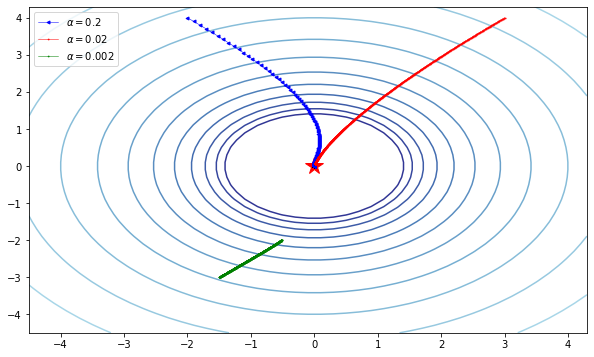

In [10]:
plt.close()
a,b = 1.0,1.0
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=np.abs(minima_surface(x,y,a,b))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)


init1=[-2,4]
init2=[3,4]
init3=[-1.5,-3]

AdaMax_traj1=AdaMax(grad_minima_surface,init1, n_epochs=1000, alpha=0.1)
AdaMax_traj2=AdaMax(grad_minima_surface,init2, n_epochs=1000, alpha=0.01)
AdaMax_traj3=AdaMax(grad_minima_surface,init3, n_epochs=1000, alpha=0.001)

overlay_trajectory_contour(ax,AdaMax_traj1,r'$\alpha=$%s'% 0.2,  'b-<', lw=0.5, ms=3)
overlay_trajectory_contour(ax,AdaMax_traj2,r'$\alpha=$%s'% 0.02, 'r-<', lw=0.5, ms=1)
overlay_trajectory_contour(ax,AdaMax_traj3,r'$\alpha=$%s'% 0.002,'g-<', lw=0.5, ms=1)

plt.legend(loc=2)
plt.show()

## 2.) Show a quantitative statistical comparison of the performance of different algorithms: <a class="anchor" id="NB2_CIV_02."></a>

- Gradient descent
- Gradient descent with momentum
- Nesterov (NAG)
- RMSprop
- ADAM
- ADAmax
- ADAgrad
- N-ADAM



* [Index](#NB2_CIV_0i.)

In [11]:
algo_str = ['GD', 'GDM', 'NAG', 'RMS-Prop', 'ADAM', 'ADAmax', 'ADAgrad', 'NADAM']

### 2.1.) ADAgrad and N-ADAM algorithms implementation <a class="anchor" id="NB2_CIV_02.1."></a>
* [Index](#NB2_CIV_i)

In [12]:
def adagrad(grad, init, n_epochs=5000, eta=10**-4,epsilon=10**-8,noise_strength=0, TIME_FLAG=False):
    if TIME_FLAG: 
        start=time.process_time()
        times=[0]
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    grad_sq=0
    G=np.array([0.,0.])
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        G = G+np.square(g)
        params=params-eta*np.divide(g,np.sqrt(G+epsilon))
        param_traj[j+1,]=params
        if TIME_FLAG: times.append(time.process_time()-start)
    if TIME_FLAG: return param_traj, np.array(times)
    else: return param_traj
    
def Nadam(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9, beta=0.999,epsilon=10**-8,noise_strength=0, TIME_FLAG=False):
    if TIME_FLAG: 
        start=time.process_time()
        times=[0]
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    m=0
    v=0
    for j in range(1,n_epochs+1):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        m=gamma*m+(1-gamma)*g
        v=beta*v+(1-beta)*g**2
        m_hat=m/(1-gamma**j)
        v_hat=v/(1-beta**j)

        params=params-eta*np.divide(gamma*m_hat + (1-gamma)*g/(1-gamma**j),np.sqrt(v_hat)+epsilon)
        param_traj[j,]=params
        if TIME_FLAG: times.append(time.process_time()-start)
    if TIME_FLAG: return param_traj, np.array(times)
    else: return param_traj

### 2.2.) Functions to find the epoch in which the convergence has been reached <a class="anchor" id="NB2_CIV_02.2."></a>
* [Index](#NB2_CIV_i)

The convergence condition is defined through a threshold. If the percentual variation at the $n^\text{th}$ epoch is below that threshold, the algorithm has converged.

In [13]:
def convergence (surface, trajectory, threshold=1e-3, n_points=3, epsilon=1e-8):
    for i in range(1,len(trajectory)-n_points):
        variation=np.zeros(n_points)
        for j in range(0, n_points):
            #variation[j]=np.linalg.norm(surface(*trajectory[i+j+1])-surface(*trajectory[i+j]))
            variation[j]=np.linalg.norm(surface(*trajectory[i+j+1])-surface(*trajectory[i+j]))/(np.linalg.norm(surface(*trajectory[i+j])) + epsilon)
        if len(variation[variation<threshold])==n_points:
            return i
    return len(trajectory)-n_points

def convergence_traj(surface, trajectory, threshold=1e-3, n_points=3, epsilon=1e-8):
    a=[]
    for i in range(1,len(trajectory)-n_points):
        #a.append(np.linalg.norm(surface(*trajectory[i+1])-surface(*trajectory[i])))
        variation=np.zeros(n_points)
        for j in range(0, n_points):
            #variation[j]=np.linalg.norm(surface(*trajectory[i+j+1])-surface(*trajectory[i+j]))
            variation[j]=np.linalg.norm(surface(*trajectory[i+j+1])-surface(*trajectory[i+j]))/(np.linalg.norm(surface(*trajectory[i+j])) + epsilon)
            if i==0:
                #a.append(np.linalg.norm(surface(*trajectory[i+j+1])-surface(*trajectory[i+j])))
                variation[j]=np.linalg.norm(surface(*trajectory[i+j+1])-surface(*trajectory[i+j]))/(np.linalg.norm(surface(*trajectory[i+j])) + epsilon)
            elif j==n_points-1:
                a.append(variation[j])
        if len(variation[variation<threshold])==n_points:
            return np.array(a), i
    return np.array(a), len(trajectory)-n_points

### 2.3.) Function for drawing multiple plots in a more practical way <a class="anchor" id="NB2_CIV_02.3."></a>
* [Index](#NB2_CIV_i)

In [14]:
def draw_curve(curve, nrows, ncols):
    figdim=6
    fig, axs =plt.subplots(nrows, ncols, figsize=(figdim*ncols, figdim*nrows))
    for i in range(0,nrows):
        for j in range(0,ncols):
            x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
            #fig, ax = plt.subplots(figsize=(10, 6))
            z=np.abs(curve(x,y))
            axs[i,j].contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
            axs[i,j].set_xlabel('$x$')
            axs[i,j].set_ylabel('$y$')
            axs[i,j].set_xlim((-4.5, 4.5))
            axs[i,j].set_ylim((-4.5, 4.5))
    
            #axs[i,j].plot(0,0, 'r*', markersize=18)
    return fig, axs

### 2.4.) Tuned parameters for every algorithm <a class="anchor" id="NB2_CIV_02.4."></a>
* [Index](#NB2_CIV_i)

The procedure of tuning has been done in the final part of the notebook.

In [15]:
gd_eta =5e-4

gdm_eta=1e-4
gdm_gamma=0.85

nag_eta=1e-4
nag_gamma=0.9

RMS_eta=0.01
RMS_beta=0.9

Adam_eta=5e-3
Adam_gamma=0.9

AdaMax_alpha=0.01
AdaMax_beta=0.9

AdaGrad_eta=0.05

Nadam_eta=0.05
Nadam_gamma=0.9

### 2.5.) Performance evaluation <a class="anchor" id="NB2_CIV_02.5."></a>
* [Index](#NB2_CIV_i)

**Note**: in order to track the CPU time at every epoch of the algorithm, the function ```process_time()``` from the module ```time``` was employed inside the implementation of the optimizers algorithms. In particular, the flag ```TIME_FLAG``` was added to the arguments of the functions of the optimizers and set by default to ```False```. In this case the optimizers just return the minimization trajectory. Otherwise, by setting ```TIME_FLAG=True```, the optimizers return also the CPU time from the beginning of the algorithm at each epoch.

#### 2.5.1.) Plots for multiple executions of every algorithm <a class="anchor" id="NB2_CIV_02.5.1."></a>
* [Index](#NB2_CIV_i)

Every algorithm has been executed $n_\text{rand points}$ times. In every execution, the starting point of the algorithm is chosen inside the region $[1,5]\times[-1.5,2.5]$, which contains the minimum of the function.

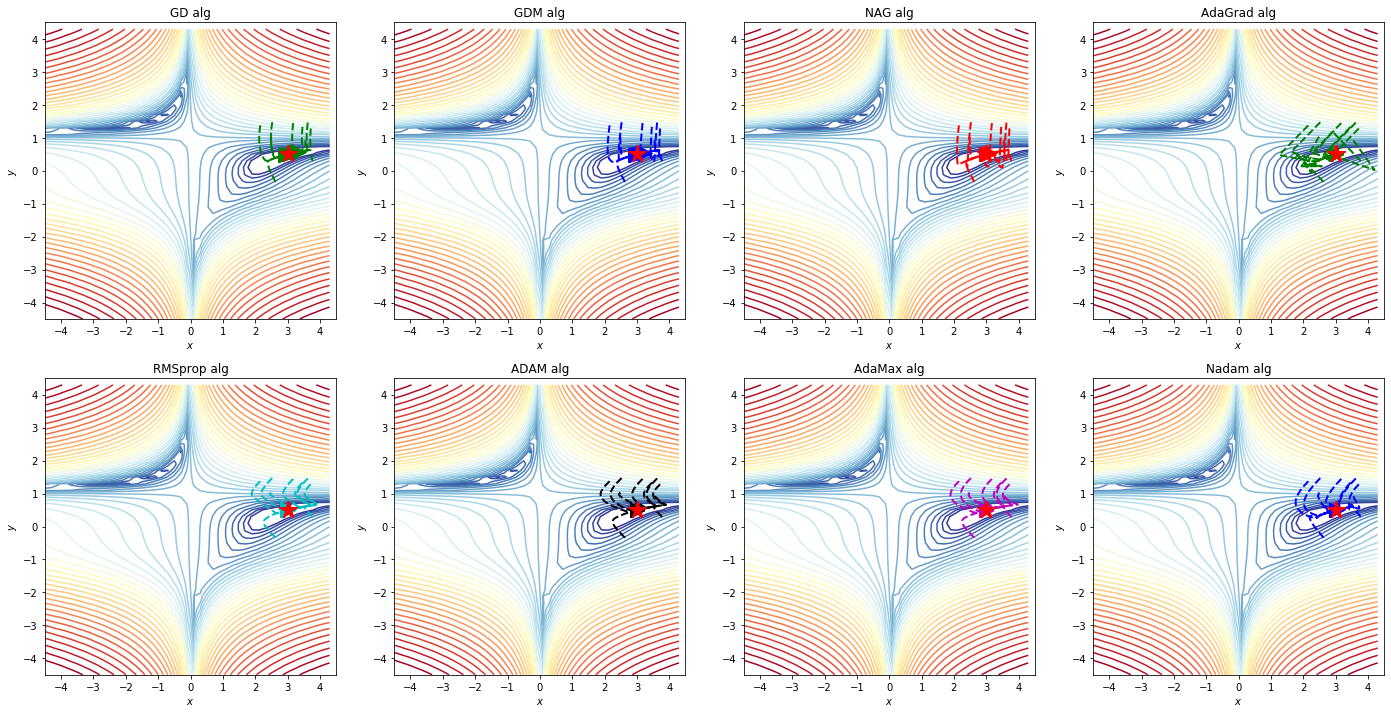

In [16]:
plt.close()
#Make static plot of the results
Nsteps=10**4
lr_l=10**-3
lr_s=10**-6


#array di punti iniziali
#init_arr=np.random.random((10,2))*8-4
#init_arr=np.array([[0,-4],[0,4],[-4,0],[4,0] ])
n_rand_points = 10
x_min, x_max = 2, 4
y_min, y_max = -0.5, 1.5
init_arr_x = np.random.uniform(x_min, x_max, size=(n_rand_points,1))
init_arr_y = np.random.uniform(y_min, y_max, size=(n_rand_points,1))
init_arr = np.concatenate((init_arr_x,init_arr_y), axis=1)
fig, axs= draw_curve(beales_function, 2,4)

#figura uno GD
for init in init_arr:
    gd_trajectory=gd(grad_beales_function,init,Nsteps, eta=gd_eta, noise_strength=0)
    overlay_trajectory_contour_M(axs[0,0],gd_trajectory, 'GD', 'g--')
    axs[0,0].plot(3,0.5, 'r*', markersize=18)
    axs[0,0].set_title("GD alg")

#GD with momentum
for init in init_arr:
    gdm_trajectory=gd_with_mom(grad_beales_function,init,Nsteps,eta=gdm_eta, gamma=gdm_gamma,noise_strength=0)
    overlay_trajectory_contour_M(axs[0,1],gdm_trajectory, 'GDM', 'b--')
    axs[0,1].plot(3,0.5, 'r*', markersize=18)
    axs[0,1].set_title("GDM alg")
#NAG
for init in init_arr:
    NAG_trajectory=NAG(grad_beales_function,init,Nsteps,eta=nag_eta, gamma=nag_gamma,noise_strength=0)
    overlay_trajectory_contour_M(axs[0,2],NAG_trajectory, 'GDM', 'r--')
    axs[0,2].plot(3,0.5, 'r*', markersize=18)
    axs[0,2].set_title("NAG alg")
    
#RMSpro
for init in init_arr:
    rms_prop_trajectory=rms_prop(grad_beales_function,init,Nsteps,eta=RMS_eta, beta=RMS_beta,epsilon=10**-8,noise_strength=0)
    overlay_trajectory_contour_M(axs[1,0],rms_prop_trajectory, 'RMSprop', 'c--')
    axs[1,0].plot(3,0.5, 'r*', markersize=18)
    axs[1,0].set_title("RMSprop alg")

#ADAM
for init in init_arr:
    adam_trajectory=adams(grad_beales_function,init,Nsteps,eta=Adam_eta, gamma=Adam_gamma, beta=0.999,epsilon=10**-8,noise_strength=0)
    overlay_trajectory_contour_M(axs[1,1],adam_trajectory, 'GDM', 'k--')
    axs[1,1].plot(3,0.5, 'r*', markersize=18)
    axs[1,1].set_title("ADAM alg")

#AdaMax
for init in init_arr:
    AdaMax_trajectory=AdaMax(grad_beales_function,init, n_epochs=Nsteps, alpha=AdaMax_alpha, beta1=AdaMax_beta, beta2=0.999)
    overlay_trajectory_contour_M(axs[1,2],AdaMax_trajectory, 'GDM', 'm--')
    axs[1,2].plot(3,0.5, 'r*', markersize=18)
    axs[1,2].set_title("AdaMax alg")

#AdaGrad
for init in init_arr:
    adagrad_trajectory=adagrad(grad_beales_function,init, n_epochs=Nsteps,eta=AdaMax_beta,epsilon=10-8, noise_strength=0)
    overlay_trajectory_contour_M(axs[0,3],adagrad_trajectory, 'GDM', 'g--')
    axs[0,3].plot(3,0.5, 'r*', markersize=18)
    axs[0,3].set_title("AdaGrad alg")

#N-ADAM
for init in init_arr:
    Nadam_trajectory=Nadam(grad_beales_function,init, n_epochs=Nsteps,eta=Nadam_eta, gamma=Nadam_gamma, beta=0.99, epsilon=10-8, noise_strength=0)
    overlay_trajectory_contour_M(axs[1,3],Nadam_trajectory, 'GDM', 'b--')
    axs[1,3].plot(3,0.5, 'r*', markersize=18)
    axs[1,3].set_title("Nadam alg") 

In [17]:
eps=1e-6
step=10


# Compute trajectories for every algorithm and for every initial condition
all_trajectories = []
all_times        = []
for init in init_arr:
    all_trajectory = []
    all_time       = []
    
    GD_______traj, GD_______time  = gd(grad_beales_function, init, Nsteps, eta=gd_eta, noise_strength=0                                                            , TIME_FLAG=True)                                                           
    GDM______traj, GDM______time  = gd_with_mom(grad_beales_function, init, Nsteps, eta=gdm_eta, gamma=gdm_gamma, noise_strength=0                                 , TIME_FLAG=True)                                
    NAG______traj, NAG______time  = NAG(grad_beales_function, init, Nsteps, eta=nag_eta, gamma=nag_gamma, noise_strength=0                                         , TIME_FLAG=True)                                        
    RMS_prop_traj, RMS_prop_time  = rms_prop(grad_beales_function, init, Nsteps, eta=RMS_eta, beta=RMS_beta, epsilon=10**-8, noise_strength=0                      , TIME_FLAG=True)                     
    ADAM_____traj, ADAM_____time  = adams(grad_beales_function, init, Nsteps,eta=Adam_eta, gamma=Adam_gamma, beta=0.999, epsilon=10**-8, noise_strength=0          , TIME_FLAG=True)          
    ADAmax___traj, ADAmax___time  = AdaMax(grad_beales_function, init, n_epochs=Nsteps, alpha=AdaMax_alpha, beta1=AdaMax_beta                                      , TIME_FLAG=True)                                     
    ADAgrad__traj, ADAgrad__time  = adagrad(grad_beales_function, init, n_epochs=Nsteps, eta=AdaGrad_eta, epsilon=10-8, noise_strength=0                           , TIME_FLAG=True)                          
    NADAM____traj, NADAM____time  = Nadam(grad_beales_function, init, n_epochs=Nsteps, eta=Nadam_eta, gamma=Nadam_gamma, beta=0.999, epsilon=10-8, noise_strength=0, TIME_FLAG=True)
    
    all_trajectory.append(GD_______traj)
    all_trajectory.append(GDM______traj)
    all_trajectory.append(NAG______traj)
    all_trajectory.append(RMS_prop_traj)
    all_trajectory.append(ADAM_____traj)
    all_trajectory.append(ADAmax___traj)
    all_trajectory.append(ADAgrad__traj)
    all_trajectory.append(NADAM____traj)
    
    all_time.append(GD_______time)
    all_time.append(GDM______time)
    all_time.append(NAG______time)
    all_time.append(RMS_prop_time)
    all_time.append(ADAM_____time)
    all_time.append(ADAmax___time)
    all_time.append(ADAgrad__time)
    all_time.append(NADAM____time)
    
    all_trajectories.append(all_trajectory)
    all_times.append(all_time)

    
# Compute loss, trajectories until convergence and number of iterations before convergence for every algorithm and for every initial condition
all_losses            = []
all_conv_trajectories = []
all_n_convs           = []
for all_traj in all_trajectories:
    all_loss            = []
    all_conv_trajectory = []
    all_n_conv          = []
    for traj in all_traj:
        all_loss.append(beales_function(traj[:,0], traj[:,1]))
        conv_traj, n_conv = convergence_traj(beales_function, traj, threshold=eps)
        all_conv_trajectory.append(conv_traj)
        all_n_conv.append(n_conv)
    all_losses.append(all_loss)
    all_conv_trajectories.append(all_conv_trajectory)
    all_n_convs.append(all_n_conv)

In [18]:
# from list to numpy array
all_trajectories      = np.array(all_trajectories     )
all_times             = np.array(all_times            )
all_losses            = np.array(all_losses           )
all_conv_trajectories = np.array(all_conv_trajectories)
all_n_convs           = np.array(all_n_convs          )


# get mean, log_mean, std and log_std
xi = 1e-30 #for numerical stabilization
all_means     = np.mean(all_losses,            axis=0)
all_log_means = np.mean(np.log(all_losses+xi), axis=0)
all_stds      = np.std (all_losses,            axis=0)
all_log_stds  = np.std (np.log(all_losses+xi), axis=0)

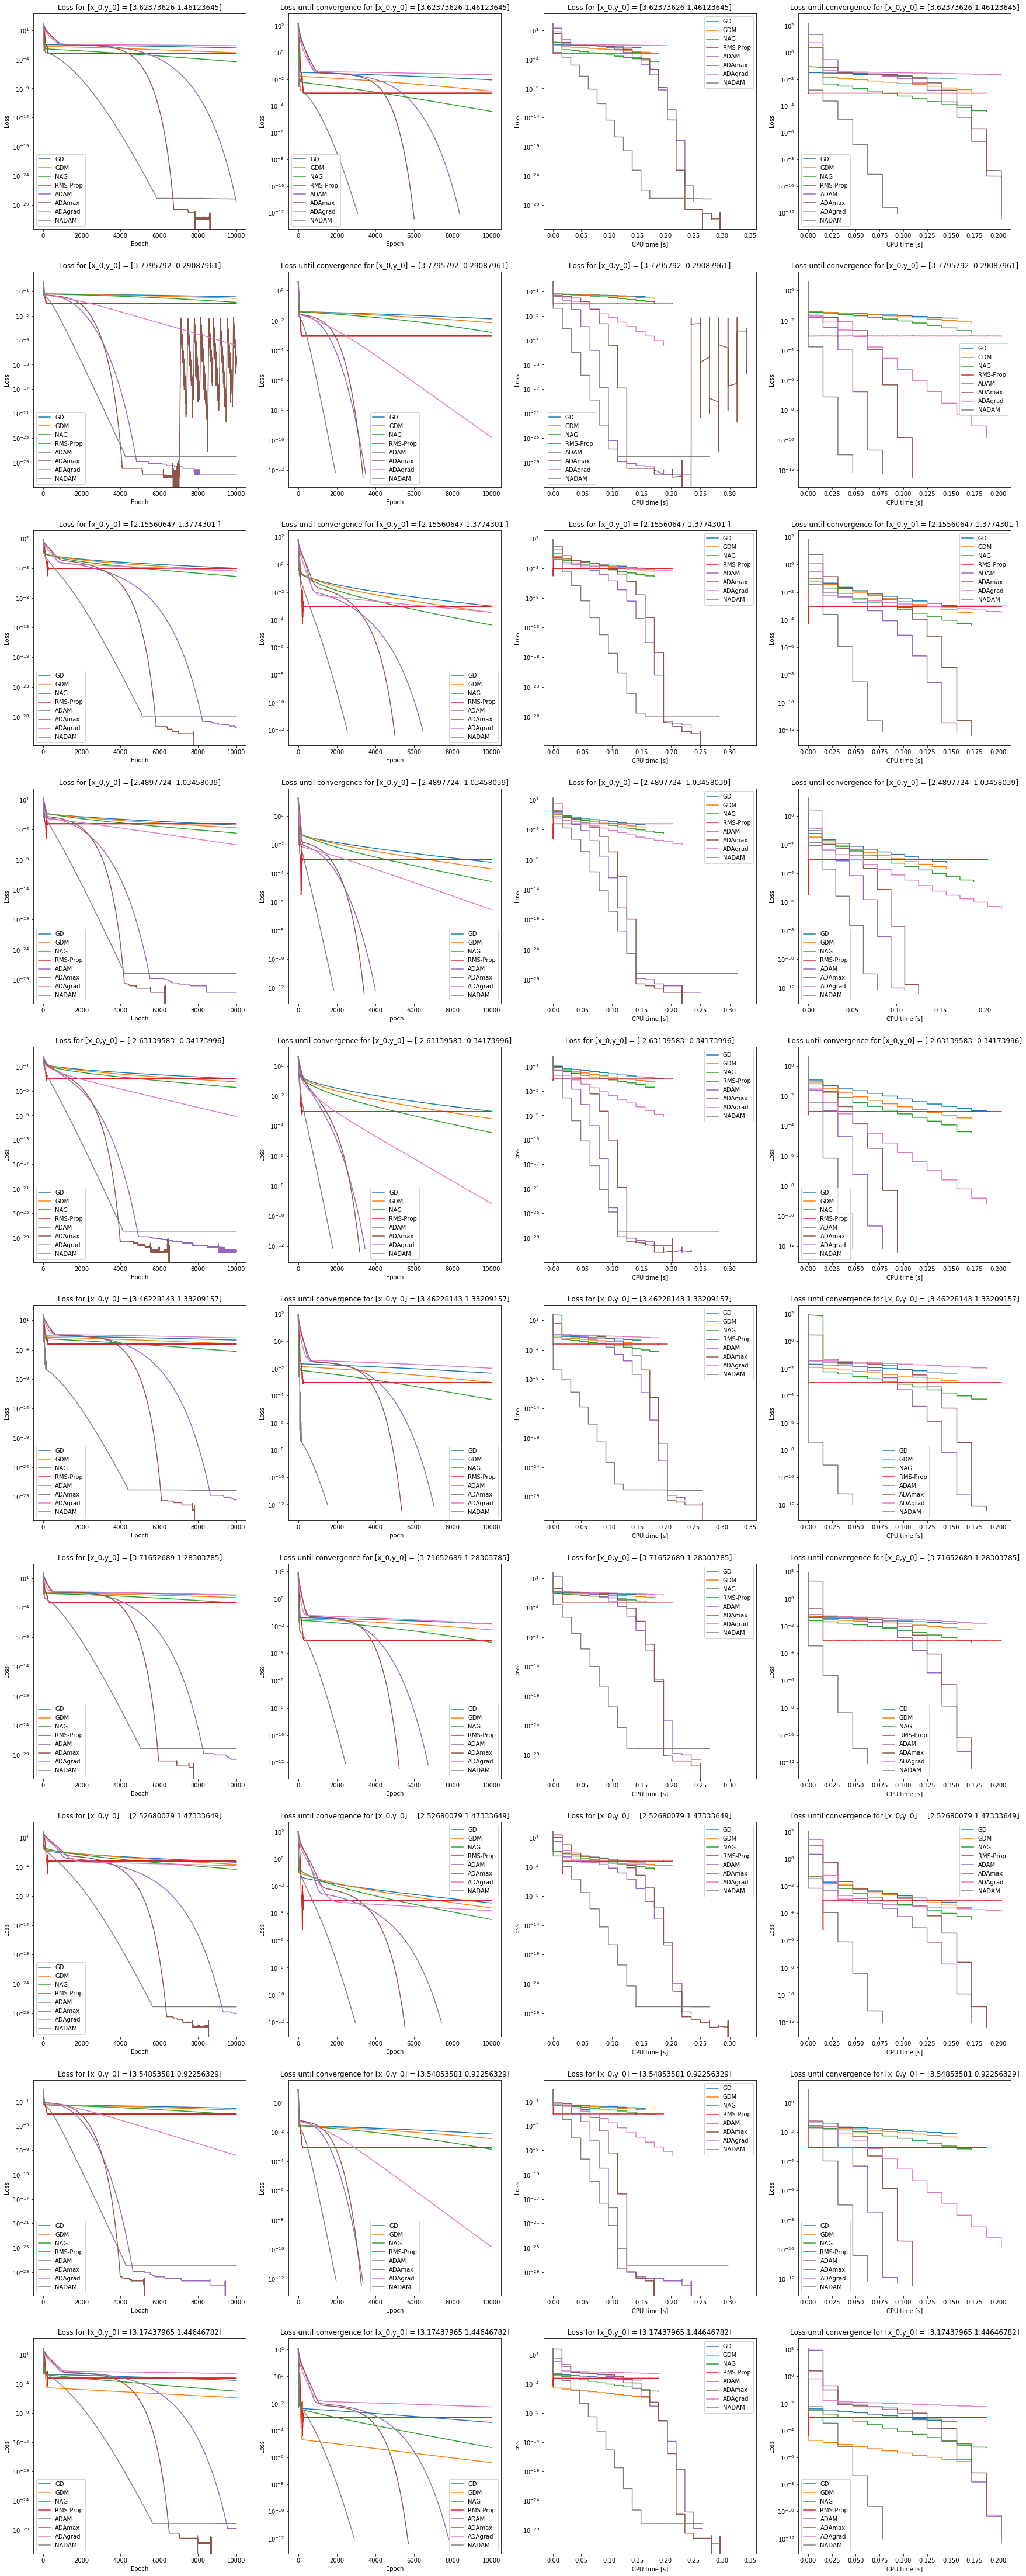

In [19]:
# plot everything with epochs (for [0] and [1]) and time (for [2] and [3]) on x-axis
plt.close()
fig, axes=plt.subplots(10,4, figsize=(30,80))

for i in range(all_trajectories.shape[0]):
    for j in range(all_trajectories.shape[1]):
        traj   = all_trajectories[i][j]
        times  = all_times[i][j]
        n_conv = all_n_convs[i][j]
        axes[i,0].plot(np.arange(len(traj)), all_losses[i][j]         , label=algo_str[j])
        axes[i,1].plot(np.arange(n_conv),    all_losses[i][j][:n_conv], label=algo_str[j])
        axes[i,2].plot(times,                all_losses[i][j]         , label=algo_str[j])
        axes[i,3].plot(times[:n_conv],       all_losses[i][j][:n_conv], label=algo_str[j])
    axes[i,0].set_title(r"Loss for [x_0,y_0] = "                   + str(init_arr[i]))
    axes[i,1].set_title(r"Loss until convergence for [x_0,y_0] = " + str(init_arr[i]))
    axes[i,2].set_title(r"Loss for [x_0,y_0] = "                   + str(init_arr[i]))
    axes[i,3].set_title(r"Loss until convergence for [x_0,y_0] = " + str(init_arr[i]))
    for k in range(0,2): axes[i,k].set_xlabel("Epoch")
    for k in range(2,4): axes[i,k].set_xlabel("CPU time [s]")
    for k in range(0,4): axes[i,k].set_ylabel("Loss")
    for k in range(0,4): axes[i,k].set_yscale("log")
    for k in range(0,4): axes[i,k].legend()

#### 2.5.2.) Mean of $n_\text{rand points}$ executions <a class="anchor" id="NB2_CIV_02.5.2."></a>
* [Index](#NB2_CIV_i)

What is possible to see is that some algorithms on average perfom better than the others tested, but with respect to this optimization problem. The best results are given by **ADAM**, **ADAmax** and **NADAM** algorithms. However, we have to point again that there is not a better algorithm in absolute term, but in relation to the task faced.

Since the mean of the results for different executions of a single algorithm is deeply affected by the result with bigger value of the Beale function, it is convenient to perform a logarithmic mean of the results, which means applying the function $\log$ to all data and then perform the mean.

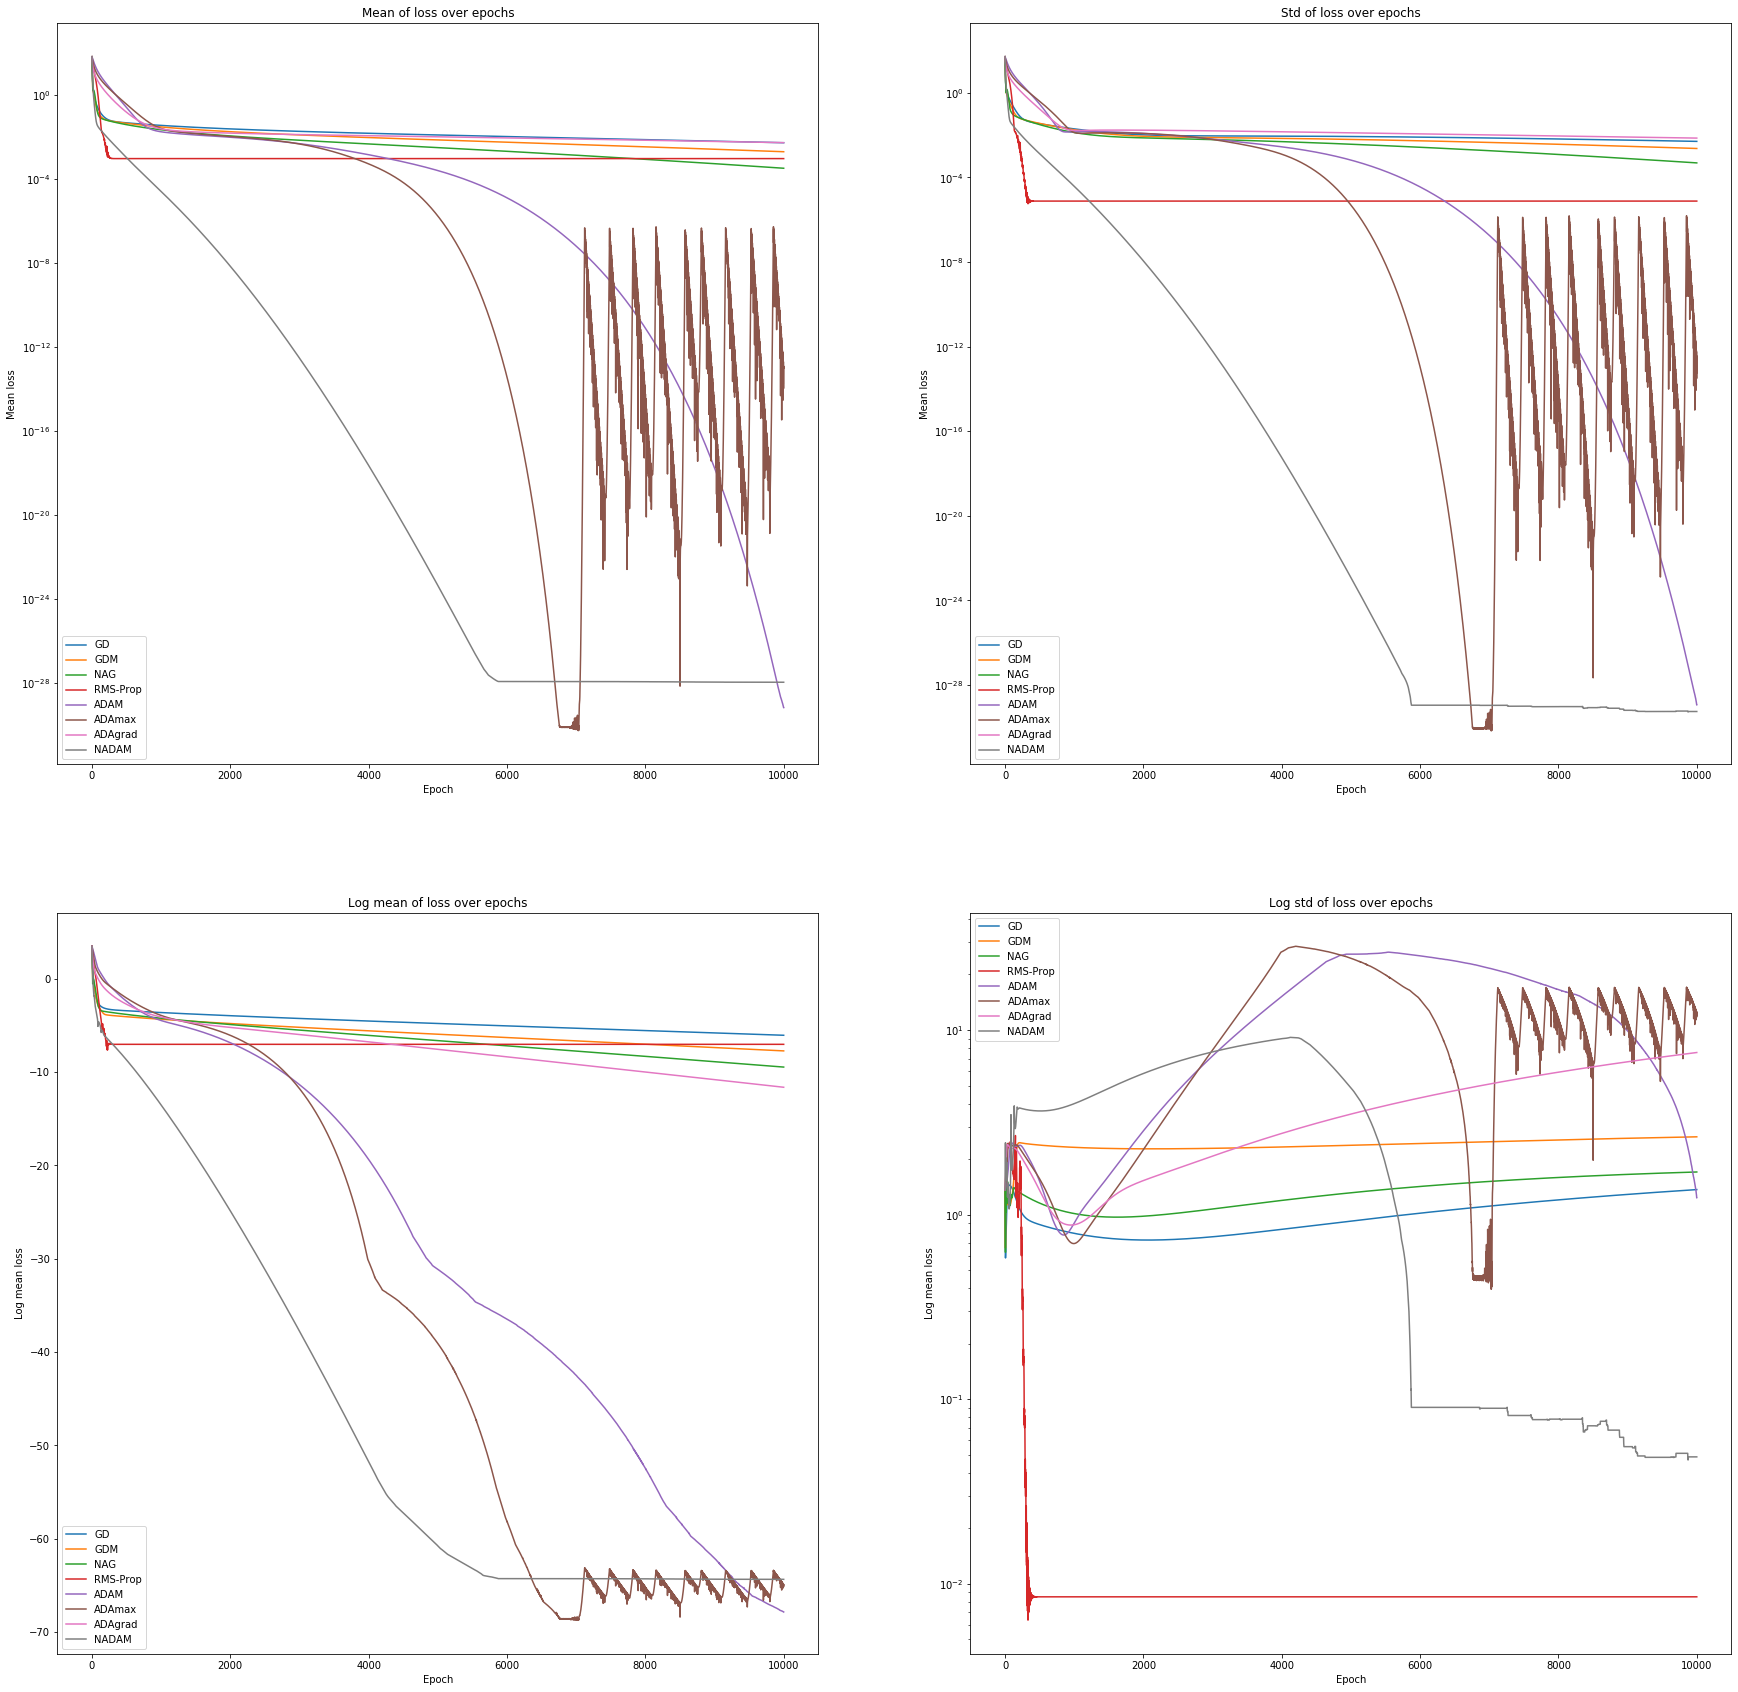

In [20]:
# plot mean, log_mean, std, log_std vs epochs and CPU time
plt.close()
fig, axes=plt.subplots(2,2, figsize=(30,30))

for i in range(all_means.shape[0]):
    axes[0,0].plot(np.arange(all_means.shape[1]), all_means[i],     label=algo_str[i])
    axes[0,1].plot(np.arange(all_stds.shape[1]),  all_stds[i],      label=algo_str[i])
    axes[1,0].plot(np.arange(all_means.shape[1]), all_log_means[i], label=algo_str[i])
    axes[1,1].plot(np.arange(all_stds.shape[1]) , all_log_stds[i],  label=algo_str[i])

axes[0,0].set_title("Mean of loss over epochs")
axes[0,1].set_title("Std of loss over epochs")
axes[1,0].set_title("Log mean of loss over epochs")
axes[1,1].set_title("Log std of loss over epochs")
for i in range(2):
    for j in range(2):
        if not (i==1 and j==0):
            axes[i,j].set_yscale("log")
        axes[i,j].legend()
        axes[i,j].set_xlabel("Epoch")
    axes[0,i].set_ylabel("Mean loss")
    axes[1,i].set_ylabel("Log mean loss")

## 3.) Show an example where ADAM algorithm starts to become unstable with respect to a minimum of the function that was reached earlier <a class="anchor" id="NB2_CIV_03."></a>
* [Index](#NB2_CIV_i)

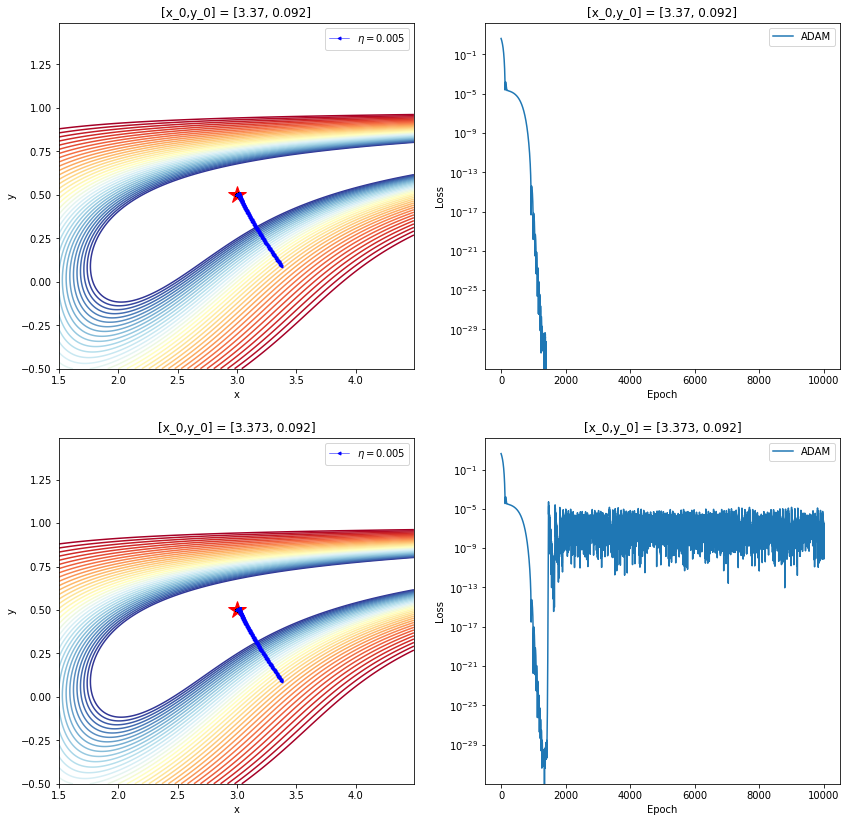

In [32]:
plt.close()
x, y = np.meshgrid(np.arange(1.5, 4.5, 0.01), np.arange(-0.5, 1.5, 0.01))
z=np.abs(beales_function(x,y))
fig, ax = plt.subplots(2,2,figsize=(14, 14))

init1 = [3.370, 0.092]
init2 = [3.373, 0.092]
init  = [init1, init2]

ax[0,0].contour(x, y, z, levels=np.logspace(0.0, 1, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax[0,0].plot(3,0.5, 'r*', markersize=18)
ax[1,0].contour(x, y, z, levels=np.logspace(0.0, 1, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax[1,0].plot(3,0.5, 'r*', markersize=18)

ADAM_traj_1 = adams(grad_beales_function, init1, n_epochs=10000, eta=5e-3, gamma=0.9, beta=0.99)
overlay_trajectory_contour(ax[0,0], ADAM_traj_1, r'$\eta =$%s'% 5e-3, 'b-<', lw=0.5, ms=3)
ax[0,1].plot(np.arange(len(ADAM_traj_1)), beales_function(ADAM_traj_1[:,0], ADAM_traj_1[:,1]), label='ADAM')
ax[0,1].set_yscale("log")

ADAM_traj_2 = adams(grad_beales_function, init2, n_epochs=10000, eta=5e-3, gamma=0.9, beta=0.99)
overlay_trajectory_contour(ax[1,0], ADAM_traj_2, r'$\eta =$%s'% 5e-3, 'b-<', lw=0.5, ms=3)
ax[1,1].plot(np.arange(len(ADAM_traj_2)), beales_function(ADAM_traj_2[:,0], ADAM_traj_2[:,1]), label='ADAM')
ax[1,1].set_yscale("log")

for i in range(2):
    ax[i,0].set_xlabel("x")
    ax[i,0].set_ylabel("y")
    ax[i,1].set_xlabel("Epoch")
    ax[i,1].set_ylabel("Loss")

for i in range(2):
    for j in range(2):
        ax[i,j].set_title(r"[x_0,y_0] = " + str(init[i]))
        ax[i,j].legend()

plt.show()

# APPENDIX

## 4.) Tuning of algorithm hyperparameters <a class="anchor" id="NB2_CIV_0A."></a>
* [Index](#NB2_CIV_i)

To enable the tuning of the hyperparameters, just set the flag ```ALGO_TUNING=True```. It is set to ```False``` by default since this operation requires a lot of time and computational resources.

In [22]:
ALGO_TUNING = False

In [23]:
if ALGO_TUNING:
    fig, axs= draw_curve(beales_function, 2,2)

    #figura uno GD
    for init in init_arr:
        gd_trajectory=gd(grad_beales_function,init,Nsteps, eta=5e-5, noise_strength=0)
        overlay_trajectory_contour_M(axs[0,0],gd_trajectory, 'GD', 'g--')
        axs[0,0].plot(3,0.5, 'r*', markersize=18)
        axs[0,0].set_title("GD alg")
    for init in init_arr:
        gd_trajectory=gd(grad_beales_function,init,Nsteps, eta=4e-5, noise_strength=0)
        overlay_trajectory_contour_M(axs[0,1],gd_trajectory, 'GD', 'g--')
        axs[0,1].plot(3,0.5, 'r*', markersize=18)
        axs[0,1].set_title("GD alg")    
    for init in init_arr:
        gd_trajectory=gd(grad_beales_function,init,Nsteps, eta=3e-5, noise_strength=0)
        overlay_trajectory_contour_M(axs[1,0],gd_trajectory, 'GD', 'g--')
        axs[1,0].plot(3,0.5, 'r*', markersize=18)
        axs[1,0].set_title("GD alg")
    for init in init_arr:
        gd_trajectory=gd(grad_beales_function,init,Nsteps, eta=2e-5, noise_strength=0)
        overlay_trajectory_contour_M(axs[1,1],gd_trajectory, 'GD', 'g--')
        axs[1,1].plot(3,0.5, 'r*', markersize=18)
        axs[1,1].set_title("GD alg")

In [24]:
if ALGO_TUNING:
    eta=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
    gamma=[0.8, 0.85, 0.9, 0.95, 0.99]

    fig, axs= draw_curve(beales_function, len(eta), len(gamma))

    for i in range(len(eta)):
        for j in range(len(gamma)):
            for init in init_arr:
                gdm_trajectory=gd_with_mom(grad_beales_function,init,Nsteps,eta=eta[i], gamma=gamma[j],noise_strength=0)
                overlay_trajectory_contour_M(axs[i,j],gdm_trajectory, 'GDM', 'b--')
                axs[i,j].plot(3,0.5, 'r*', markersize=18)
                axs[i,j].set_title("GDM alg, eta="+str(eta[i])+", gamma= "+str(gamma[j]))

In [25]:
if ALGO_TUNING:
    eta=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
    gamma=[0.8, 0.85, 0.9, 0.95, 0.99]

    fig, axs= draw_curve(beales_function, len(eta), len(gamma))

    for i in range(len(eta)):
        for j in range(len(gamma)):
            for init in init_arr:
                NAG_trajectory=NAG(grad_beales_function,init,Nsteps,eta=eta[i], gamma=gamma[j],noise_strength=0)
                overlay_trajectory_contour_M(axs[i,j],NAG_trajectory, 'GDM', 'r--')
                axs[i,j].plot(3,0.5, 'r*', markersize=18)
                axs[i,j].set_title("NAG alg, eta="+str(eta[i])+", gamma= "+str(gamma[j]))

In [26]:
if ALGO_TUNING:
    eta=[0.1, 0.05, 1e-2, 1e-3, 1e-4]
    beta=[0.8, 0.85, 0.9, 0.95, 0.99]

    fig, axs= draw_curve(beales_function, len(eta), len(beta))

    for i in range(len(eta)):
        for j in range(len(beta)):
            for init in init_arr:
                rms_prop_trajectory=rms_prop(grad_beales_function,init,Nsteps,eta=eta[i], beta=beta[j],epsilon=10**-8,noise_strength=0)
                overlay_trajectory_contour_M(axs[i,j],rms_prop_trajectory, 'RMSprop', 'b--')
                axs[i,j].plot(3,0.5, 'r*', markersize=18)
                axs[i,j].set_title("RMSprop alg, eta="+str(eta[i])+", beta= "+str(beta[j]))

In [27]:
if ALGO_TUNING:
    eta=[0.1, 0.01, 0.005, 1e-3, 1e-4]
    gamma=[0.8, 0.85, 0.9, 0.95, 0.99]
    beta=[0.9,0.99, 0.999]
    fig, axs= draw_curve(beales_function, len(eta), len(gamma))

    for i in range(len(eta)):
        for j in range(len(gamma)):
            for init in init_arr:
                adam_trajectory=adams(grad_beales_function,init,Nsteps,eta=eta[i], gamma=gamma[j], beta=0.99,epsilon=10**-8,noise_strength=0)
                overlay_trajectory_contour_M(axs[i,j],adam_trajectory, 'GDM', 'r--')
                axs[i,j].plot(3,0.5, 'r*', markersize=18)
                axs[i,j].set_title("ADAM alg, eta="+str(eta[i])+", gamma= "+str(gamma[j]))

In [28]:
if ALGO_TUNING:
    alpha=[0.1, 0.05, 0.01, 1e-3, 1e-4]
    beta1=[0.8, 0.85, 0.9, 0.95, 0.99]
    beta2=[0.9,0.99, 0.999]
    fig, axs= draw_curve(beales_function, len(alpha), len(beta1))

    for i in range(len(alpha)):
        for j in range(len(beta1)):
            for init in init_arr:
                adamax_trajectory=AdaMax(grad_beales_function,init,n_epochs=Nsteps,alpha=alpha[i], beta1=beta1[j],beta2=0.999, noise_strength=0)
                overlay_trajectory_contour_M(axs[i,j],adamax_trajectory, 'ADAMAX', 'r--')
                axs[i,j].plot(3,0.5, 'r*', markersize=18)
                axs[i,j].set_title("ADAMAX alg, alpha="+str(alpha[i])+", beta1= "+str(beta1[j]))

In [29]:
if ALGO_TUNING:
    eta=np.array([[0.5, 0.1, 0.05], [0.01, 0.005, 0.001],
         [5e-4, 1e-4, 5e-5], [1e-5, 5e-6,6e-6 ]])
    fig, axs= draw_curve(beales_function, eta.shape[0], eta.shape[1])


    for i in range(eta.shape[0]):
        for j in range(eta.shape[1]):
            for init in init_arr:
                adagrad_trajectory=adagrad(grad_beales_function,init, n_epochs=Nsteps,eta=eta[i,j],epsilon=10-8, noise_strength=0)
                overlay_trajectory_contour_M(axs[i,j],adagrad_trajectory, 'ADAGRAD', 'g--') 
                axs[i,j].plot(3,0.5, 'r*', markersize=18)
                axs[i,j].set_title("ADAGRAD alg, eta= "+str(eta[i,j]))

In [30]:
if ALGO_TUNING:
    eta=[0.1, 0.05, 0.001, 5e-4, 1e-4]
    gamma=[0.8, 0.85, 0.9, 0.95, 0.99]

    fig, axs= draw_curve(beales_function, len(eta), len(gamma))

    for i in range(len(eta)):
        for j in range(len(beta1)):
            for init in init_arr:
                Nadam_trajectory=Nadam(grad_beales_function,init, n_epochs=Nsteps,eta=eta[i], gamma=gamma[j], beta=0.99, epsilon=10-8, noise_strength=0)
                overlay_trajectory_contour_M(axs[i,j],Nadam_trajectory, 'GDM', 'b--')
                axs[i,j].plot(3,0.5, 'r*', markersize=18)
                axs[i,j].set_title("NADAM alg, eta="+str(alpha[i])+", gamma= "+str(gamma[j]))